## Семинар 9: "LSTM"

ФИО: Коновалов Михаил Анатольевич

In [683]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
import pandas
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.nn import MSELoss
from tqdm.notebook import tqdm
%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [117]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        
        self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        
    def forward(self, inputs, hidden):
        # inputs: (seq_len, batch_size, input_size)
        # hidden: (batch_size, hidden_size) x 2. (no layers)
        
        h, c = hidden
        bs = h.size(0)
        
        seq_length = inputs.size(0)
        out = torch.Tensor(seq_length, bs, self.hidden_size)
        
        for i, inp in enumerate(inputs):
            S = torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b
            S = S.view(bs, 4, self.hidden_size)
            i_1 = torch.sigmoid(S[:, 0, :])
            f_1 = torch.sigmoid(S[:, 1, :])
            g_1 = torch.tanh(S[:, 2, :])
            o_1 = torch.sigmoid(S[:, 3, :])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
        return out, (h, c)

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.
С помощью обученной сети получить из train-части временного ряда test-часть.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

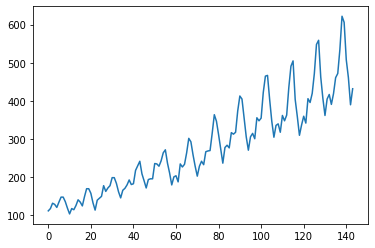

In [679]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [527]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1-look_forward):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back : (i + look_back + look_forward), 0])

    return np.array(dataX), np.array(dataY)

In [688]:
def prepare_train_test(dataset, look_back, batch_size):
    dataset = dataset.values
    dataset = dataset.astype('float32')
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    
    train_size = int(len(dataset) * 0.67)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    
    test_dataset = TensorDataset(torch.from_numpy(testX), torch.from_numpy(testY))
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_dataset, train_dataloader, test_dataset, test_dataloader

In [689]:
train_dataset, train_dataloader, test_dataset, test_dataloader = prepare_train_test(dataset, 10, 10)

In [660]:
class Network(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Network, self).__init__()
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size)
        self.linear = nn.Linear(hidden_size, 1)
        
        
    def forward(self, inputs):
        lstm_output, (h, c) = self.lstm(inputs)
        linear_output = self.linear(h)
        return linear_output

In [744]:
def train_model(hidden_size, n_epochs, look_back, lr=1e-3):
    loss = nn.MSELoss()
    input_size = 1

    model = Network(input_size, hidden_size)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for i in tqdm(range(n_epochs), total=n_epochs):
        loss_values = []
        for batch in train_dataloader:
            X = batch[0]
            y = batch[1]

            optimizer.zero_grad()
            output = model(X.reshape(look_back, X.shape[0], 1))
            loss_value = loss(output, y)
            loss_value.backward()
            optimizer.step()
            loss_values.append(loss_value.data)
        if not i % 100:
            print(i, sum(loss_values) / len(loss_values))
    print(i, sum(loss_values) / len(loss_values))
    return model

In [745]:
def make_full_plot(model, dataloader, dataset):
    outs = []
    for batch in dataloader:
        X = batch[0]
        output = model(X.reshape(10, X.shape[0], 1))
        outs += list(output[0, :, 0].data)

    plt.plot(dataset.tensors[1], c="red", label="Data")
    plt.plot(outs, c="blue", label="Model")
    plt.legend()
    plt.show()

In [746]:
def make_point_by_point_plot(model, dataloader, dataset, look_back):
    for batch in dataloader:
        start = batch[0][0][0]
        break

    outputs = []

    for i in range(dataset.tensors[0].shape[0] - 1):
        output = model(start.reshape(look_back, 1, 1))
        outputs.append(float(output))
        for j in range(look_back - 1):
            start[j] = start[j + 1]
        start[9] = float(output)

    plt.plot(dataset.tensors[1], c="red", label="Data")
    plt.plot(outputs, c="blue", label="Model")
    plt.legend()
    plt.show()

In [747]:
look_back = 10
batch_size = 10
train_dataset, train_dataloader, test_dataset, test_dataloader = prepare_train_test(dataset, look_back, batch_size)

Вывести метрику на тесте для каждой эпохи

Сделать метрику для point-by-point

придумать, как ввести ее в лосс

написать нормальный инференс

In [750]:
model = train_model(256, 10000, look_back, 1e-2)

0 tensor(0.0472)
100 tensor(0.0017)
200 tensor(0.0020)
300 tensor(0.0017)
400 tensor(0.0022)
500 tensor(0.0014)
600 tensor(0.0006)
700 tensor(0.0002)
800 tensor(0.0014)
900 tensor(0.0003)
1000 tensor(0.0015)
1100 tensor(0.0002)
1200 tensor(0.0015)
1300 tensor(5.4309e-05)
1400 tensor(0.0004)
1500 tensor(0.0001)
1600 tensor(0.0003)
1700 tensor(0.0016)
1800 tensor(9.0058e-05)
1900 tensor(0.0003)
2000 tensor(1.9356e-05)
2100 tensor(0.0002)
2200 tensor(5.0407e-05)
2300 tensor(3.3714e-06)
2400 tensor(0.0001)
2500 tensor(4.5539e-05)
2600 tensor(1.4646e-05)
2700 tensor(0.0001)
2800 tensor(1.4998e-05)
2900 tensor(6.1237e-05)
3000 tensor(0.0007)
3100 tensor(8.8209e-05)
3200 tensor(0.0003)
3300 tensor(0.0002)
3400 tensor(5.8175e-05)
3500 tensor(1.7714e-05)
3600 tensor(3.8585e-06)
3700 tensor(2.2119e-05)
3800 tensor(0.0001)
3900 tensor(0.0001)
4000 tensor(0.0004)
4100 tensor(1.4843e-05)
4200 tensor(0.0001)
4300 tensor(5.1689e-05)
4400 tensor(1.4106e-06)
4500 tensor(3.7060e-05)
4600 tensor(0.0001)


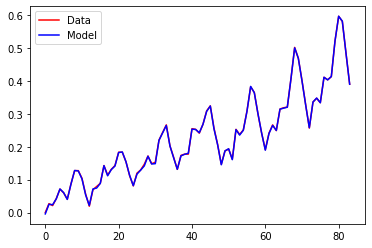

In [751]:
make_full_plot(model, train_dataloader, train_dataset)

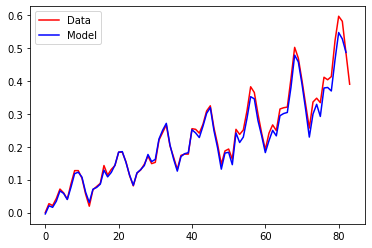

In [752]:
make_point_by_point_plot(model, train_dataloader, train_dataset, look_back)

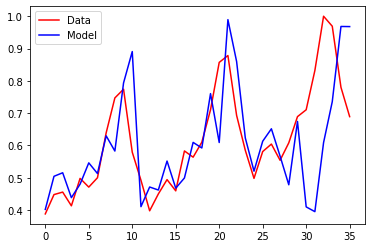

In [753]:
make_full_plot(model, test_dataloader, test_dataset)

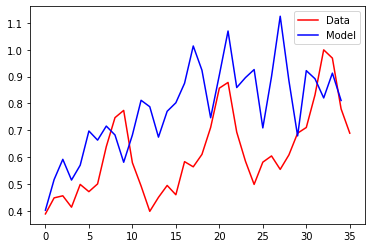

In [754]:
make_point_by_point_plot(model, test_dataloader, test_dataset, look_back)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: